<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/TensorFlow/TensorFlow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Preprocessing
###Preparing Tabular Data for Training

In [ ]:
import functools
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"
train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

In [ ]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


In [ ]:
train_df = pd.read_csv(train_file_path, header='infer')
test_df = pd.read_csv(test_file_path, header='infer')

In [ ]:
for col in train_df:
    print(col.dtype)

AttributeError: ignored

###Marking columns

In [ ]:
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

train_ds = tf.data.experimental.make_csv_dataset(train_file_path, batch_size=3, 
                                                 label_name=LABEL_COLUMN, 
                                                 na_value="?", num_epochs=1,
                                                 ignore_errors=True)
test_ds = tf.data.experimental.make_csv_dataset(test_file_path, batch_size=3,
                                                label_name=LABEL_COLUMN,
                                                na_value="?", num_epochs=1,
                                                ignore_errors=True)

In [ ]:
for batch, label in train_ds.take(1):
    print(label)
    for key, value in batch.items():
        print("{:12s}: {}".format(key,value.numpy()))

tf.Tensor([0 1 0], shape=(3,), dtype=int32)
sex         : [b'male' b'female' b'male']
age         : [51. 28. 40.]
n_siblings_spouses: [0 0 0]
parch       : [1 0 0]
fare        : [ 61.3792 110.8833  27.7208]
class       : [b'First' b'First' b'First']
deck        : [b'unknown' b'unknown' b'unknown']
embark_town : [b'Cherbourg' b'Cherbourg' b'Cherbourg']
alone       : [b'n' b'y' b'y']


###Table data prepartion
1. Designate columns by feature types

In [ ]:
feature_columns = []
# numeric cols
for header in ['age', 'n_siblings_spouses', 'parch', 'fare']:
    feature_columns.append(feature_column.numeric_column(header))

In [ ]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

Create a binned/bucketized column

| Age range        | Description |
| -----------------| ----------- |
| < 23             | [1, 0, 0, 0]|
| >= 23 but < 28   | [0, 1, 0, 0]|
| >= 28 but < 35   | [0, 0, 1, 0]|
| >= 35            | [0, 0, 0, 1]|

In [ ]:
# binning
age = feature_column.numeric_column('age')
age_buckets = feature_column.bucketized_column(age, boundaries=[23, 28, 35])
demo(age_buckets)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# Categorical columns
h = {}
for col in titanic_df:
    if col in ['sex', 'class', 'deck', 'embark_town', 'alone']:
        print(col, ':', titanic_df[col].unique())
        h[col] = titanic_df[col].unique()

sex : ['male' 'female']
class : ['Third' 'First' 'Second']
deck : ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town : ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone : ['n' 'y']


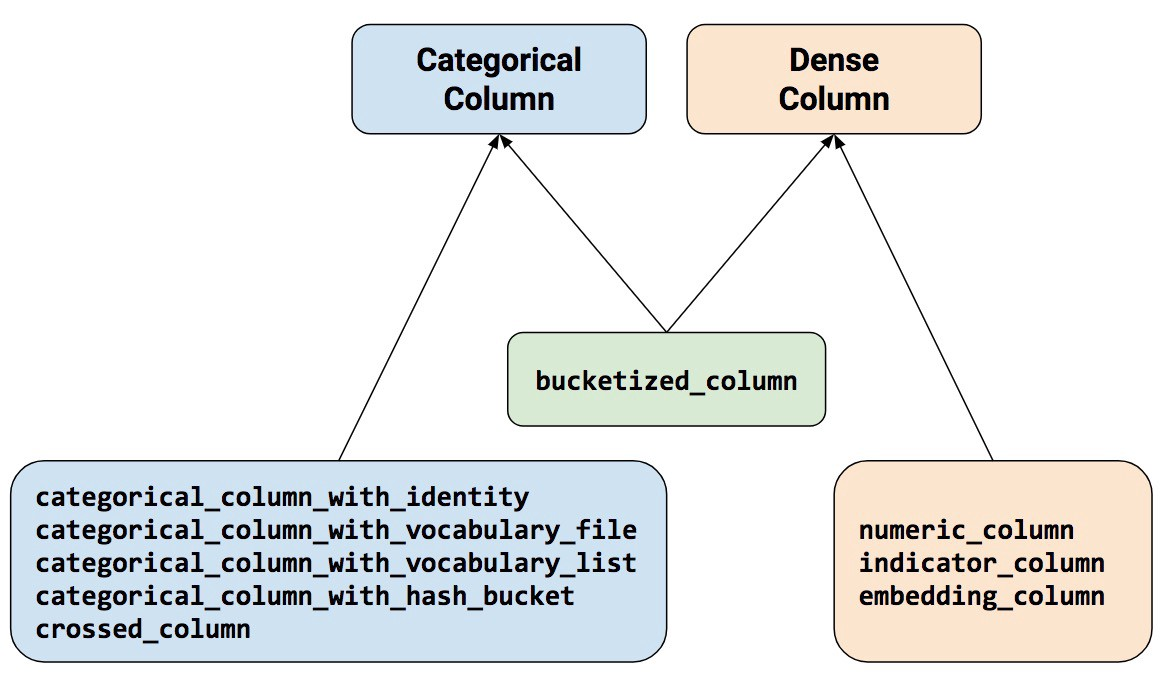

Putting feature columns together

In [ ]:
feature_columns = []

# append numeric columns
for header in ['age', 'n_siblings_spouses', 'parch', 'fare']:
    feature_columns.append(feature_column.numeric_column(header))

# append bucketized columns
age = feature_column.numeric_column('age')
age_buckets = feature_column.bucketized_column(age, boundaries=[23, 28, 35])
feature_columns.append(age_buckets)

# append categorical columns
indicator_column_names = ['sex', 'class', 'deck', 'embark_town', 'alone']
for col_name in indicator_column_names:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(col_name, train_df[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

# append embedding columns
deck = feature_column.categorical_column_with_vocabulary_list('deck', train_df.deck.unique())
deck_embedding = feature_column.embedding_column(deck, dimension=3)
feature_columns.append(deck_embedding)

# append crossed columns
cross_type_feature = feature_column.crossed_column(['sex', 'class'], hash_bucket_size=5)
feature_columns.append(feature_column.indicator_column(cross_type_feature))

# create a feature layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

A utility function to convert pandas dataframes to tensorflow datasets

In [ ]:
def pandas_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('survived')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

Creating a cross-validation dataset

In [ ]:
val_df, test_df = train_test_split(test_df, test_size=0.4)
print(len(train_df), 'train examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples')

627 train examples
158 validation examples
106 test examples


Creating a batched tensorflow dataset

In [ ]:
train_df.head(5)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
batch_size = 32
labels = train_df.pop('survived')
working_ds = tf.data.Dataset.from_tensor_slices((dict(train_df), labels))
working_ds = working_ds.shuffle(buffer_size=len(train_df))
train_ds = working_ds.batch(batch_size)

Creating the validation and test datasets

In [ ]:
val_ds = pandas_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds = pandas_to_dataset(test_df, shuffle=False, batch_size=batch_size)

Start the model training process

In [ ]:
type(tf.keras.Input(shape=(3,)))

keras.engine.keras_tensor.KerasTensor

In [ ]:
# Sequential model
"""
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])
"""

# Functional API
inputs = {}

for col, datatype in zip(train_df.columns, train_df.dtypes):
    inputs[col] = tf.keras.Input(shape=(1,), dtype=datatype) 

x = feature_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(.1)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
20/20 [==============================] - 2s 23ms/step - loss: 0.8450 - accuracy: 0.6316 - val_loss: 0.7512 - val_accuracy: 0.6139
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.7348 - accuracy: 0.6667 - val_loss: 0.6006 - val_accuracy: 0.6835
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.6963 - accuracy: 0.6667 - val_loss: 0.7115 - val_accuracy: 0.6519
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.6527 - accuracy: 0.6794 - val_loss: 0.5812 - val_accuracy: 0.6266
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.5971 - accuracy: 0.6842 - val_loss: 0.5603 - val_accuracy: 0.6772
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.5707 - accuracy: 0.6842 - val_loss: 0.6305 - val_accuracy: 0.6835
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.5881 - accuracy: 0.7113 - val_loss: 0.5599 - val_accuracy: 0.6519
Epoch 8/10
20/20 [=

###Preparing image data for processing

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import pathlib

Download the flower dataset

In [2]:
data_dir = tf.keras.utils.get_file('flower_photos', 
                                   'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                   untar=True)

228827136/228813984 [==============================] - 1s 0us/step


In [3]:
!ls -lrt ~/.keras/datasets/flower_photos

total 608
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  40960 Feb 10  2016 tulips
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  49152 Feb 10  2016 dandelion
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy


In [4]:
!ls -lrt ~/.keras/datasets/flower_photos/roses | head -10

total 40116
-rw-r----- 1 270850 5000  33399 Jan 11  2016 7409458444_0bfc9a0682_n.jpg
-rw-r----- 1 270850 5000 102758 Jan 11  2016 7345657862_689366e79a.jpg
-rw-r----- 1 270850 5000  78640 Jan 11  2016 9337528427_3d09b7012b.jpg
-rw-r----- 1 270850 5000  32020 Jan 11  2016 7551637034_55ae047756_n.jpg
-rw-r----- 1 270850 5000 108384 Jan 11  2016 5736328472_8f25e6f6e7.jpg
-rw-r----- 1 270850 5000  40554 Jan 11  2016 3997609936_8db20b7141_n.jpg
-rw-r----- 1 270850 5000  24761 Jan 11  2016 3903276582_fe05bf84c7_n.jpg
-rw-r----- 1 270850 5000  39699 Jan 11  2016 3751835302_d5a03f55e8_n.jpg
-rw-r----- 1 270850 5000  26655 Jan 11  2016 3667366832_7a8017c528_n.jpg


A helper function that displays an image in its original size

In [5]:
def display_image_in_actual_size(im_path):
    dpi = 100
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axis that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(im_data, cmap='gray')
    plt.show()

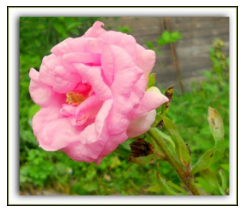

In [6]:
IMAGE_PATH = "/root/.keras/datasets/flower_photos/roses/7409458444_0bfc9a0682_n.jpg"
display_image_in_actual_size(IMAGE_PATH)

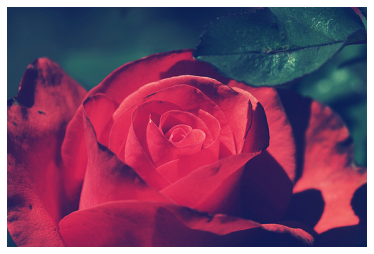

In [7]:
IMAGE_PATH = "/root/.keras/datasets/flower_photos/roses/5736328472_8f25e6f6e7.jpg"
display_image_in_actual_size(IMAGE_PATH)

Transforming images to a fixed specification

In [8]:
pixels = 224
BATCH_SIZE = 32
IMAGE_SIZE = (pixels, pixels)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, 
                       batch_size=BATCH_SIZE, 
                       interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(data_dir, subset="validation", 
                                                    shuffle=False,
                                                    **dataflow_kwargs)

train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(data_dir, subset="training", 
                                                    shuffle=True, 
                                                    **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [9]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 5)


In [9]:
labels_idx = train_generator.class_indices
idx_labels = dict((v,k) for k,v in labels_idx.items())
print(idx_labels)

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}


In [ ]:
import pickle

with open('prediction_lookup.pickle', 'wb') as handle:
    pickle.dump(idx_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('prediction_lookup.pickle', 'rb') as handle:
    lookup = pickle.load(handle)

Training the model using ResNet

In [10]:
import tensorflow_hub as hub

NUM_CLASSES = 5
mdl = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
                           hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/4", trainable=False),
                           tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name = 'custom_class')])
mdl.build([None, 224, 224, 3])

mdl.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=0.1),metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
mdl.fit(train_generator, epochs=5, steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


91/91 [==============================] - 38s 231ms/step - loss: 0.9323 - accuracy: 0.8060 - val_loss: 0.7577 - val_accuracy: 0.8636
Epoch 2/5
91/91 [==============================] - 20s 221ms/step - loss: 0.6557 - accuracy: 0.9033 - val_loss: 0.7289 - val_accuracy: 0.8565
Epoch 3/5
91/91 [==============================] - 20s 218ms/step - loss: 0.5869 - accuracy: 0.9364 - val_loss: 0.7112 - val_accuracy: 0.8707
Epoch 4/5
91/91 [==============================] - 19s 212ms/step - loss: 0.5500 - accuracy: 0.9594 - val_loss: 0.6760 - val_accuracy: 0.8935
Epoch 5/5
91/91 [==============================] - 19s 213ms/step - loss: 0.5324 - accuracy: 0.9663 - val_loss: 0.6945 - val_accuracy: 0.8750


###Preparing text data for processing

In [2]:
import tensorflow as tf
import numpy as np
import os
import time

In [3]:
FILE_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
FILE_NAME = 'shakespeare.txt'
path_to_file = tf.keras.utils.get_file(FILE_NAME, FILE_URL)

1130496/1115394 [==============================] - 0s 0us/step


In [4]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [6]:
print(text[:400])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [8]:
vocabulary = sorted(set(text))
print ('There are {} unique characters'.format(len(vocabulary)))
print(vocabulary[:20])

There are 65 unique characters
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G']


In [9]:
vocabulary = sorted(set(text.lower()))
print ('There are {} unique characters'.format(len(vocabulary)))

There are 39 unique characters


In [10]:
vocabulary_word = sorted(set(text.lower().split(' ')))
print ('There are {} unique words'.format(len(vocabulary_word)))

There are 41623 unique words


Creating a Dictionary and Reverse Dictionary

In [12]:
char_to_index = {u:i for i, u in enumerate(vocabulary)}
index_to_char = {i:u for i, u in enumerate(vocabulary)}